# German Numer

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans

from vi_svi_class_experiments import run_methods
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Loading german numer

In [70]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/german_numer(1000,24).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'german'
file_name = data_name

x_tr = x_tr.T
x_tr = x_tr.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr)

x_tr = (x_tr + 1) / 2
y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]
dim, num = x_tr.shape
print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 800
of features: 24
german


## K-Means cluster centers

In [3]:
ind_num = 50
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [4]:
cov_params = np.array([1., .5, 0.01])

## svi-L-BFGS-B-c method

In [7]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
new_gp = GPC(model_covariance_obj, method='svi')

In [8]:
opts = {'mode': 'full', 'maxiter': 200, 'mydisp': False}
svi_res = new_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

In [9]:
metric = lambda w: new_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=1)

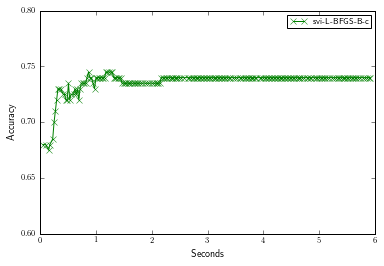

In [10]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.6, 0.8])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [11]:
svi_res.params[-1][:3]

array([  9.58838891e+00,   1.42344778e+01,   1.00000000e-02])

## vi-means-c method

In [12]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
new_gp = GPC(model_covariance_obj, method='vi')

In [13]:
opts = {'maxiter':5, 'mydisp': False}
vi_res = new_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=100)

In [14]:
metric = lambda w: new_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1)

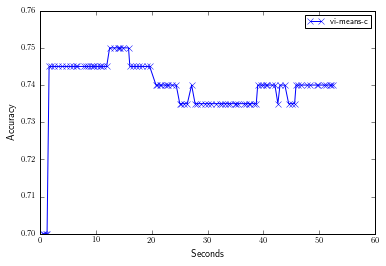

In [15]:
plt.plot(vi_x_lst[1:100], vi_y_lst[1:100], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.7, 0.76])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c

In [61]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
new_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 500, 'verbose': True, 'batch_size': 50, 'step_rate': 0.05,
       'decay': 0.5, 'print_freq':50}
batch_res = new_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Iteration  800 :
	Gradient norm 2.05710207573
Iteration  1600 :
	Gradient norm 1.6316523566
Iteration  2400 :
	Gradient norm 3.38630964978
Iteration  3200 :
	Gradient norm 4.41304371035
Iteration  4000 :
	Gradient norm 4.79071252854
Iteration  4800 :
	Gradient norm 5.98695340753
Iteration  5600 :
	Gradient norm 6.44962060059
Iteration  6400 :
	Gradient norm 7.22929313514
Iteration  7200 :
	Gradient norm 8.37064068202
Iteration  8000 :
	Gradient norm 9.09620355969


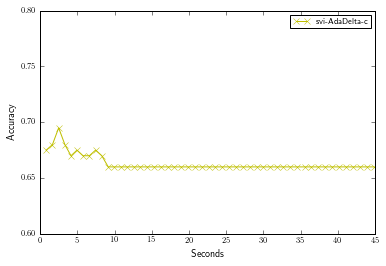

In [63]:
metric = lambda w: new_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=10)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0.6, 0.8])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

Я попробовал разные варианты параметров для этого метода, пробовал менять начальное приближение, но он все равно не сходится к тому же решению.
Попробуем использовать все данные на каждой итерации.

In [64]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
new_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 5000, 'verbose': True, 'batch_size': 800, 'step_rate': 0.1,
       'decay': 0.5, 'print_freq':50}
non_batch_res = new_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Iteration  50 :
	Gradient norm 148.085348376
Iteration  100 :
	Gradient norm 138.238242461
Iteration  150 :
	Gradient norm 128.07462186
Iteration  200 :
	Gradient norm 117.158276955
Iteration  250 :
	Gradient norm 105.349028615
Iteration  300 :
	Gradient norm 92.394280937
Iteration  350 :
	Gradient norm 78.4020815668
Iteration  400 :
	Gradient norm 64.4031585426
Iteration  450 :
	Gradient norm 52.3043746659
Iteration  500 :
	Gradient norm 45.8000503165
Iteration  550 :
	Gradient norm 47.4645217784
Iteration  600 :
	Gradient norm 49.2200970771
Iteration  650 :
	Gradient norm 51.161660043
Iteration  700 :
	Gradient norm 52.2784228943
Iteration  750 :
	Gradient norm 52.0698598042
Iteration  800 :
	Gradient norm 50.4436335598
Iteration  850 :
	Gradient norm 47.8203564079
Iteration  900 :
	Gradient norm 45.0881325297
Iteration  950 :
	Gradient norm 42.4472379541
Iteration  1000 :
	Gradient norm 39.9251203999
Iteration  1050 :
	Gradient norm 37.538059444
Iteration  1100 :
	Gradient norm 35.2

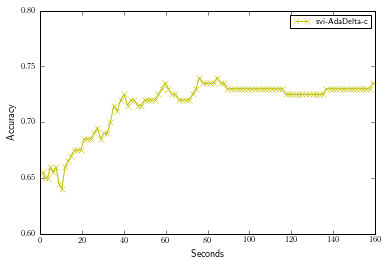

In [66]:
metric = lambda w: new_gp.get_prediction_quality(w, x_test, y_test)
svi_fad_x_lst, svi_fad_y_lst = non_batch_res.plot_performance(metric, 't', freq=50)
plt.plot(svi_fad_x_lst[1:], svi_fad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0.6, 0.8])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

В данном случае метод смог сойтись к тому же качеству, что и два других.

## Выводы

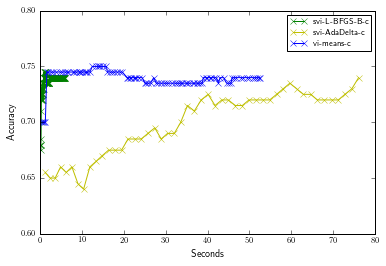

In [68]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_fad_x_lst[1:50], svi_fad_y_lst[1:50], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:100], vi_y_lst[1:100], '-bx', label='vi-means-c')
plt.ylim([0.6, 0.8])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

На данном датасете метод AdaDelta сильно проиграл. Чтобы он сошелся к хорошему решению, пришлось отказаться от стохастической оптимизации, а из-за того, что он не учитывает информацию второго порядка, он сходится в таком виде очень долго.

In [71]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'ad_x.npy', svi_fad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'ad_y.npy', svi_fad_y_lst)